# LAB 5.3 - Transformer - BERT

The labs require a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

In [ ]:
import os
def downgrade_tf_version():
    os.system("!yes | pip uninstall -y tensorflow")
    os.system("!yes | pip install tensorflow==2.12.0")
    os.kill(os.getpid(), 9)
downgrade_tf_version()

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [2]:
from local.lib.rlxmoocapi import submit, session
import inspect
session.LoginSequence(endpoint=init.endpoint,course_id=init.course_id, lab_id="L05.03", varname="student");

In [3]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x

In [4]:
!pip install tensorflow-text==2.12.1

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

## Example:

**Let's take a look to the following example about the use of BERT model from Tensorflow_hub**

We are going to use the same dataset for sentiment analysis than in the LAB 5.2

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math

In [7]:
data = pd.read_csv('local/data/Tweets.csv')
# Keeping only the neccessary columns
data = data[['text','airline_sentiment']]

In [8]:
import re
pd.options.mode.chained_assignment = None  # default='warn'
#Remove neutral class
data = data[data.airline_sentiment != "neutral"]

#text normalization
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x:re.sub('@[^\s]+','',x)))#remove the name of the airline
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
Np = np.sum(data['airline_sentiment'].values == 'positive')
Nn = np.sum(data['airline_sentiment'].values == 'negative')
print(f'Number of positive samples={Np}')
print(f'Number of negative samples={Nn}')
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

In [9]:
data[:10]

**We can use a pre-trained BERT from tensorflow hub.**

In [10]:
bert_preprocess_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1",trainable=False)

BERT model requires three inputs: ids, mask and segments.

- ids: correspond to the tokenized word sequence.
- mask: is used for MLM training phase.
- segments: is used for NSP training pahse.

Take a look to ids,mask and segments for a toy example:

In [11]:
s = ["This is a nice sentence."]
text_preprocessed = bert_preprocess_model(s)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')

Note that the `bert_preprocess_model` layer sets the sequence length to 128 by default, which means it applies padding to shorter sequences and truncates longer ones.

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
input_text = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess_model(input_text)
outputs = bert_layer(preprocessed_text)
model = Model(inputs=input_text, outputs=[outputs['pooled_output'], outputs['sequence_output']])

In [13]:
pool_embs, all_embs = model.predict(["This is a nice sentence."])

BERT provides 768 dimension embedding for each token in the given sentence. Note that it gives you two different ouputs: pool_embs and all_embs. all embs is the embedding of the whole sequence and pool_embs is the embedding of the initial CLS token. It's "pooled" from all input tokens in the sense that the multiple attention layers will force it to depend on all other tokens.

In [14]:
pool_embs.shape

In [15]:
all_embs.shape

Let's prepare the data for training and validation

In [16]:
from sklearn.preprocessing import LabelEncoder
y = data['airline_sentiment'].values
Encoder = LabelEncoder()
Y = Encoder.fit_transform(y)

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout

In [19]:
from sklearn.model_selection import train_test_split
all_sentences = data['text'].values
input_segments_tr, input_segments_te, y_tr, y_te = train_test_split(all_sentences, Y, test_size=0.2, random_state=2018)

In [20]:
input_text = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess_model(input_text)
outputs = bert_layer(preprocessed_text)
recurrent = LSTM(128,activation='tanh')(outputs['sequence_output'])
dense1 = Dense(10,activation='relu')(recurrent)
drop1 = Dropout(0.3)(dense1)
dense2 = Dense(1,activation='sigmoid')(drop1)
model2 = Model(inputs=input_text, outputs=dense2)

In [ ]:
model2.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
model2.fit(input_segments_tr, y_tr, validation_split=0.1,batch_size=32, epochs=3, verbose=1)

In [ ]:
y_pred = np.round(model2.predict(input_segments_te))

In [ ]:
from sklearn.metrics import recall_score, accuracy_score
def especi_score(y_te,y_pred):
    Ns = np.sum(y_te == 0)
    return np.sum(y_te[y_te == 0] == y_pred[y_te == 0])/Ns

In [ ]:
print('Accuracy = {}'.format(accuracy_score(y_te,y_pred)))
print('Sensitivity = {}'.format(recall_score(y_te,y_pred)))
print('Especificity = {}'.format(especi_score(y_te,y_pred.flatten())))

## Task 1:

Create a layer class TokenAndPositionEmbedding similar to the one used in the course material [U5.08](https://rramosp.github.io/2021.deeplearning/content/U5.08%20-%20Self-Attention%20-%20Transformer%20-%20BERT.html) , but in this case define it such that returns word Embedding vectors plus non trainable sinusoidal positional embeddings, which must be set according to the embedding dimension and maximum length of the sentences.

The sinusoidal positional embedding can be estimated as:

$$PE_{(pos,2i)} = \sin\left(\frac{pos}{10000^{2i/d_e}}\right)$$,
$$PE_{(pos,2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_e}}\right)$$

where $pos$ is the position in the embedding vector, $d_e =$ embedding dimension and $i \in [0,d_e/2]$. Remember to keep $pos$ 0 for padding token position encoding zero vector.

For a $d_e = 100$ and sequences with a maximum length of 200, the positional embedding matrix must look like this:

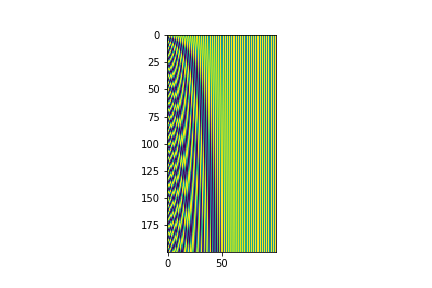

In [ ]:

from IPython.display import Image
Image(filename='local/imgs/positional_embeddings.png', width=600)


In [ ]:
def TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim):
    class _TokenAndPositionEmbedding(layers.Layer):
        def __init__(self, maxlen, vocab_size, embed_dim):
            ...
        def call(self, x):
            ...
        return token_embeddings + pos_embeddings
    return _TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)

**Submit your solution:**

In [ ]:
student.submit_task(namespace=globals(), task_id='T1');

## Task 2:

Create a function 'get_transformer_model' that define a DL model for the sentiment analysis prediction problem. The model must have the following architecture:

- The former token + positional embedding layer created in task 1
- Two Transformer Blocks (remember to take a look to the [class material](https://rramosp.github.io/2021.deeplearning/content/U5.08%20-%20Self-Attention%20-%20Transformer%20-%20BERT.html#example-sentiment-analysis-using-a-transformer-block))
- A GlobalAveragePooling1D layer
- A droput(rate) layer
- A dense layer with 20 neurons
- A droput(rate) layer
- One Output layer

In [ ]:
def get_transformer_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim, rate=0.1):

    #maxlen: sequences length
    #vocab_size: dictionary size
    #embed_dim: embedding dimension
    #num_heads: number of heads for MultiHeadAttention attention layer
    #ff_dim: number of neurons in the dense layer of the transformer block
    #rate: drop rate for all droput layers

    model = ...

    return model

The following is the architecture you should get for the given parameters:

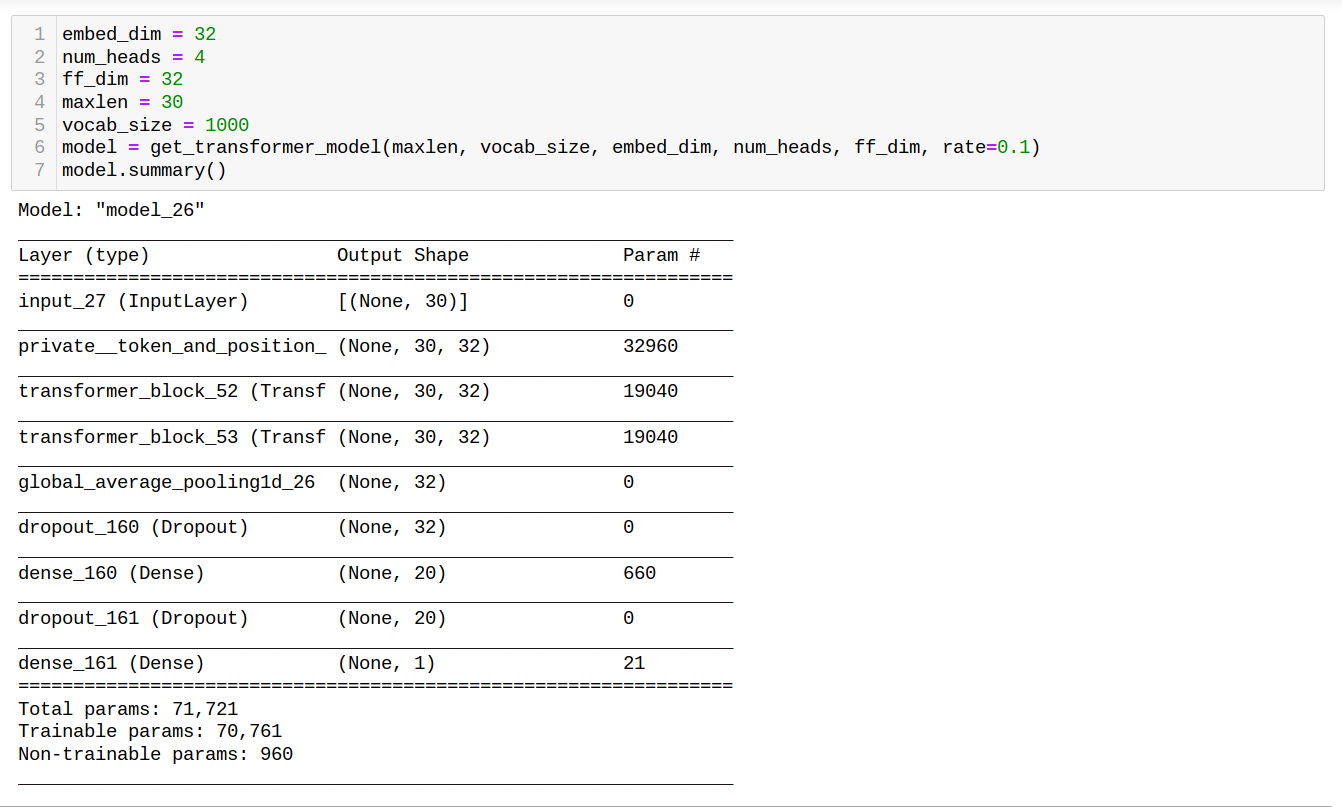

In [ ]:

from IPython.display import Image
Image("local/imgs/TransformerArch.png")


**Submit your solution:**

In [ ]:
student.submit_task(namespace=globals(), task_id='T2');

### Let's test the model:

**Warning**: Run this part only if you have already passed Tasks 1 and 2.

In [ ]:
# Removing Stop Words
import nltk
nltk.download('punkt_tab')
from nltk.corpus import stopwords
all_sentences = data['text'].values
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
stop_words = stopwords.words('english')
stop_words.append('')

for i in range(len(all_words)):
    all_words[i] = [w for w in all_words[i] if (w not in stop_words) and (not w.isdigit())]

In [ ]:
from local.lib.DataPreparationRNN import preprocessed_seq
tokenizer, X = preprocessed_seq(data['text'].values)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
y = data['airline_sentiment'].values
Encoder = LabelEncoder()
Y = Encoder.fit_transform(y)
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.2, random_state=2018)
classes = np.unique(Y)
class_weight_vect = compute_class_weight('balanced',classes=classes,y=y_tr)
class_weight = {classes[0]: class_weight_vect[0],
                classes[1]: class_weight_vect[1]}

In [ ]:
embed_dim = 32
num_heads = 4
ff_dim = 32
model = get_transformer_model(X.shape[1], tokenizer.num_words, embed_dim, num_heads, ff_dim, rate=0.1)

In [ ]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_tr, y_tr, validation_split=0.1,batch_size=32,epochs=20, class_weight=class_weight) #

In [ ]:
from sklearn.metrics import recall_score, accuracy_score
def especi_score(y_te,y_pred):
    Ns = np.sum(y_te == 0)
    return np.sum(y_te[y_te == 0] == y_pred[y_te == 0])/Ns

In [ ]:
y_pred = np.round(model.predict(X_te))
sensitivity = recall_score(y_te,y_pred)
accuracy = accuracy_score(y_te,y_pred)
especificity = especi_score(y_te,y_pred.flatten())

In [ ]:
sensitivity

In [ ]:
especificity

**UNGRADED TASK**

Repeat the former experiment but declaring equally weighted classes during training instead; compare the results with the ones you just got.